# mmWave MIMO channel

0
1
2
3
4
5
6
7
8
9


Text(0.5, 0, 'SNRdB')

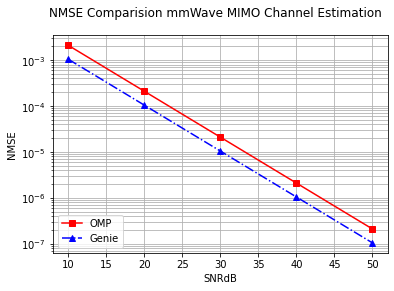

In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

t = 32; r = 32;
numRF = 8;   # Number of RF chains
N_Beam = 24; # Number of PILOT symbols << no of transmit antennas
G = 32;      # Number of array response vectors in dictionary (denotes the Grid size)
ITER = 10;   # Number of iterations
L = 5;       # Number of multi paths or no of non zero elements in the matrix

omp_thrld = 10; # Threshold for stopping criteria
SNRdB = np.arange(10,55,10);
SNR = 10**(SNRdB/10);
mseOMP = np.zeros(len(SNRdB));  # Mean square error for OMP
mseGenie = np.zeros(len(SNRdB));  # MSE for Genie method

# Create the dictionary for receive and transmit array response vectors
A_T = MIMO.ArrayDictionary(G,t); # G array response vectors of size t*1
A_R = MIMO.ArrayDictionary(G,r); # G array response vectors of size r*1

# Create the RF, Baseband precoders
FRF,FBB = MIMO.RF_BB_matrices(t,numRF,N_Beam);
# Create the RF and Baseband combiners
WRF,WBB = MIMO.RF_BB_matrices(r,numRF,N_Beam);
# Q_tilde is created here using Kronecker product
Qtil = np.kron(np.matmul(np.transpose(FBB),np.transpose(FRF)),np.matmul(MIMO.H(WBB),MIMO.H(WRF)));

for ix in range(ITER):
  print(ix);
  # Generate MIMO channel alpha = complex gain
  # Psi = known dictionary matrix when Angle of arrival and departure are known
  # A_R_Genie and A_T_Genie are array response vectors when we have perfect knowledge of angles of arrival
  alpha, Psi, A_R_genie, A_T_genie = MIMO.mmWaveMIMOChannelGenerator(A_R,A_T,G,L);
  # Create a MIMO channel matrix H = A-r*H_b*A_T^Hermitian
  H = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(alpha),MIMO.H(A_T_genie)]);

  # Channel noise vector is being created
  ChNoise = 1/np.sqrt(2)*(nr.normal(0,1,(N_Beam,N_Beam)) + 1j*nr.normal(0,1,(N_Beam,N_Beam)));
  for cx in range(len(SNRdB)):
    # Received matrix of Pilots consider pilot matrix as Identity matrix
    Yrec = np.sqrt(SNR[cx])*nl.multi_dot([MIMO.H(WBB),MIMO.H(WRF),H,FRF,FBB]) + ChNoise;
    # Convert the matrix into vector order = 'F' means reshaping must be column wise
    # y = N_Beam*N_Beam
    y = np.reshape(Yrec,(N_Beam*N_Beam,1),order='F');

    # Q is the overall sensing matrix given in notes
    Q = np.sqrt(SNR[cx])*np.matmul(Qtil,np.kron(np.conj(A_T),A_R));
    hb_OMP = MIMO.OMP(y,Q,omp_thrld); # hb_OMP = beamspace sparse channel vector
    # H_OMP is r*t matrix A_T = r*G hb_OMP = G*G A_T_Hermtian = G*t
    H_OMP = nl.multi_dot([A_R, np.reshape(hb_OMP,(G,G), order='F'), MIMO.H(A_T)]);
    mseOMP[cx] = mseOMP[cx] + nl.norm(H-H_OMP)**2/(t*r); # mean square error is found here

    Qbar = np.sqrt(SNR[cx])*np.matmul(Qtil,Psi);  # Perfect knowledge of Ang of arr and depart. is assumed here
    alphaEst = np.matmul(nl.pinv(Qbar),y); # Least square estimator
    # Gives a H_Genie matrix when we perfectly know the AoA and AoD
    H_Genie = nl.multi_dot([A_R_genie, np.diag(alphaEst.flatten()),MIMO.H(A_T_genie)]);
    # save the mean square error for genie estimator
    mseGenie[cx] = mseGenie[cx] + nl.norm(H-H_Genie)**2/(t*r);

mseOMP = mseOMP/ITER;
mseGenie = mseGenie/ITER;

plt.yscale('log')
plt.plot(SNRdB, mseOMP,'r-s');
plt.plot(SNRdB, mseGenie,'b^-.');
plt.grid(1,which='both')
plt.legend(["OMP", "Genie"], loc ="lower left");
plt.suptitle('NMSE Comparison mmWave MIMO Channel Estimation')
plt.ylabel('NMSE')
plt.xlabel('SNRdB')